In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.join('..'))
from model import GreyboxModel

# load experiment parameters
exptname = 'reaction-diffusion'
trialname = 'demo'
mode = 'adaptive'
with open(os.path.join('..', 'params.yaml'), 'r') as fd:
    params = yaml.safe_load(fd)

### Preparation

In [2]:
# load log
with np.load(os.path.join('..', 'out', trialname, mode, 'curve_tr.npz')) as data:
    loss_tr = data['L_tr']
    loss_va = data['L_va']

# load test data
with np.load(os.path.join('..', 'out', trialname, 'data_te.npz')) as data:
    x = data['x']
    y = data['y']
    thT = data['thT']

# load model
model = GreyboxModel(params['model'])
model.load_state_dict(torch.load(os.path.join('..', 'out', trialname, mode, 'model_te.pt')))
model.eval()

GreyboxModel(
  (net_fD_mlp): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
  (net_fD_conv): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=replicate)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=replicate)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  )
)

### Inspect learning curves

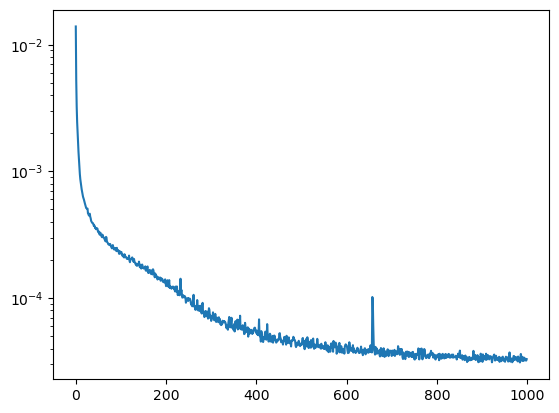

In [3]:
epochs_tr = np.array(list(range(0, loss_tr.shape[0])))
# epochs_va = np.array(list(range(0, loss_tr.shape[0], params['train']['common']['valid_interval_epochs'])))

plt.plot(epochs_tr, np.mean(loss_tr, axis=1))
# plt.plot(epochs_va, np.mean(loss_va, axis=1))
plt.yscale('log')
# plt.legend(['train', 'validation'])
plt.show()

### Prediction example

In [4]:
# prediction on test data
with torch.no_grad():
    pred_thT = model.prm_thT_fixed
    pred_y, R = model(torch.tensor(x).float())

pred_thT = pred_thT.detach().numpy()    
pred_y = pred_y.detach().numpy()

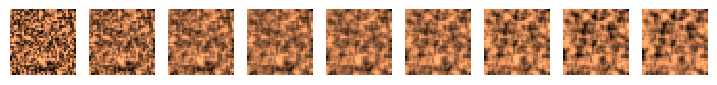

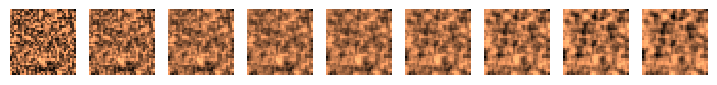

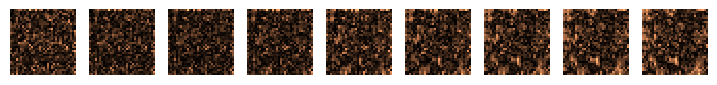

In [5]:
# plot
sample_idx = 0

def show_patterns(U, ax=None):
    ax.imshow(U, cmap=plt.cm.copper, interpolation='nearest', extent=[-1, 1, -1, 1])
    ax.set_axis_off()

for _y_to_be_plotted in [pred_y, y, np.abs(pred_y-y)]:
    fig, axes = plt.subplots(1, 9, figsize=(9, 2))
    for i in range(9):
        ax = axes.flat[i]
        time_index = i*int(pred_y.shape[1]/8)
        show_patterns(_y_to_be_plotted[sample_idx,time_index,1,:,:], ax=ax)
        # ax.set_title(f'$t={t_eval[time_index]:.2f}$')

### Surface of R

In [6]:
# show surface of R
sample_idx = 0

n = 21
aa, bb = np.meshgrid(
    np.linspace(params['model']['thT_bound'][0][0], params['model']['thT_bound'][0][1], n),
    np.linspace(params['model']['thT_bound'][1][0], params['model']['thT_bound'][1][1], n)
)

mse = np.zeros((n, n))
normD = np.zeros((n, n))
abs_dotTD = np.zeros((n, n))
for i in range(aa.shape[0]):
    for j in range(aa.shape[1]):
        a = aa[i,j]
        b = bb[i,j]
        with torch.no_grad():
            pred_y, _normD, _abs_dotTD= model(
                torch.tensor(x[sample_idx]).float().unsqueeze(0),
                thT=torch.tensor([a, b]).float().unsqueeze(0),
                return_all_R=True
            )
        mse[i,j] = np.mean((pred_y.squeeze(0).detach().numpy() - y[sample_idx])**2)
        normD[i,j] = _normD.item()
        abs_dotTD[i,j] = _abs_dotTD.item()

RMSE


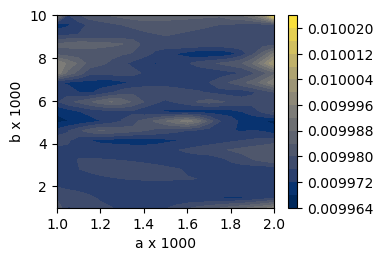

||f_D||^2


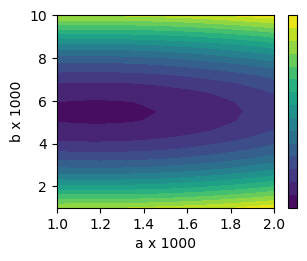

|<f_T,f_D>|


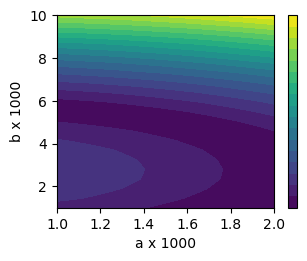

||f_D||^2 + |<f_T,f_D>|


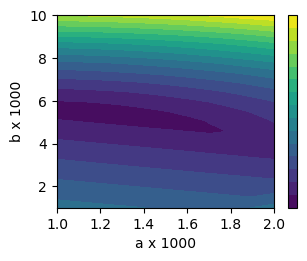

||f_D||^2 * |<f_T,f_D>| (in log scale)


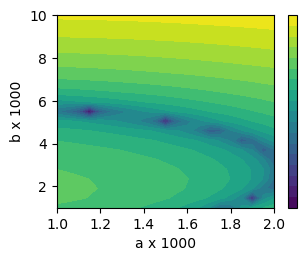

In [15]:
targets_and_names = [
    (np.sqrt(mse), r'RMSE'),
    (normD, '||f_D||^2'),
    (abs_dotTD, '|<f_T,f_D>|'),
    (normD+abs_dotTD, '||f_D||^2 + |<f_T,f_D>|'),
    (np.log(normD*abs_dotTD), '||f_D||^2 * |<f_T,f_D>| (in log scale)')
]

for i,target_and_name in enumerate(targets_and_names):
    plt.figure(figsize=(3.5,2.5))
    plt.contourf(aa*1000, bb*1000, target_and_name[0], levels=16, cmap='viridis' if i>0 else 'cividis')
    cb = plt.colorbar()
    if i > 0:
        cb.set_ticks([])
    plt.xlabel('a x 1000')
    plt.ylabel('b x 1000')
    # plt.title(target_and_name[1])
    print(target_and_name[1])
    plt.show()